In [1]:
# !pip install speechbrain==1.0.0
# !pip install torch torchaudio

In [58]:
# !pip install librosa
# !pip install pydub

In [1]:
from pathlib import Path
from cloudpathlib import AnyPath, GSClient
import glob
from tqdm import tqdm
import IPython.display as display
from IPython.display import Audio
import pandas as pd, numpy as np, matplotlib.pyplot as plt

import torchaudio
import librosa
import librosa.display
from pydub import AudioSegment

## Set up variables

In [35]:
USERS = ["g28_huawei", "g28_moto", "debug"]
USERS_PATH = AnyPath("gs://data_labear/users")
# Data is downloaded locally to labear/data/users/{user}/{file}.m4a
LOCAL_DATA = Path("../data")
# Preprocessed data is stored at labear/data/experiments/{EXP_NAME}
EXP_NAME = "v1"
EXP_DIR = Path(f"../data/experiments/{EXP_NAME}")
EXP_DIR.mkdir(exist_ok=True, parents=True)
# Have to hardcode the categories for now due to inconsistent naming in file system
CATS = ["air", "vac", "off"]

## Download data from storage (gs://data_labear/users)

In [2]:
assert GSClient().client.project == "labear", "Set google project to labear!"

In [7]:
# Download files from storage 
for u in USERS:
    # Copy files to local path
    for in_path in (USERS_PATH / u).glob("**/*.m4a"):
        out_path = LOCAL_DATA / "users" / u / in_path.name
        out_path.parent.mkdir(exist_ok=True)
        if out_path.exists():
            print(f"Skipping {in_path}")
            continue
        else:
            print(f"Writing {in_path} to {out_path}")
            with in_path.open("rb") as f:
                with out_path.open("wb") as g:
                    g.write(f.read())      

Skipping gs://data_labear/users/g28_huawei/data/raw/g28_huawei_air_1725874893229.m4a
Skipping gs://data_labear/users/g28_huawei/data/raw/g28_huawei_air_1726229487294.m4a
Skipping gs://data_labear/users/g28_huawei/data/raw/g28_huawei_off_1725875099788.m4a
Skipping gs://data_labear/users/g28_huawei/data/raw/g28_huawei_off_1726154947369.m4a
Skipping gs://data_labear/users/g28_huawei/data/raw/g28_huawei_vac_1725874725453.m4a
Skipping gs://data_labear/users/g28_huawei/data/raw/g28_huawei_vac_1726154772068.m4a
Skipping gs://data_labear/users/g28_moto/data/raw/g28_air_1724341697486.m4a
Skipping gs://data_labear/users/g28_moto/data/raw/g28_air_1724429751887.m4a
Skipping gs://data_labear/users/g28_moto/data/raw/g28_off_1724341915322.m4a
Skipping gs://data_labear/users/g28_moto/data/raw/g28_off_1724429832899.m4a
Skipping gs://data_labear/users/g28_moto/data/raw/g28_vac_1724341530251.m4a
Skipping gs://data_labear/users/g28_moto/data/raw/g28_vac_1724429578031.m4a
Writing gs://data_labear/users/deb

## Preprocess data into chunks with labels

In [8]:
# Collect local files
files = []
for u in USERS:
    files += (LOCAL_DATA / "users" / u).glob("**/*.m4a")
files

[PosixPath('../data/users/g28_huawei/g28_huawei_air_1726229487294.m4a'),
 PosixPath('../data/users/g28_huawei/g28_huawei_vac_1726154772068.m4a'),
 PosixPath('../data/users/g28_huawei/g28_huawei_air_1725874893229.m4a'),
 PosixPath('../data/users/g28_huawei/g28_huawei_off_1725875099788.m4a'),
 PosixPath('../data/users/g28_huawei/g28_huawei_vac_1725874725453.m4a'),
 PosixPath('../data/users/g28_huawei/g28_huawei_off_1726154947369.m4a'),
 PosixPath('../data/users/g28_moto/g28_vac_1724341530251.m4a'),
 PosixPath('../data/users/g28_moto/g28_off_1724341915322.m4a'),
 PosixPath('../data/users/g28_moto/g28_vac_1724429578031.m4a'),
 PosixPath('../data/users/g28_moto/g28_off_1724429832899.m4a'),
 PosixPath('../data/users/g28_moto/g28_air_1724429751887.m4a'),
 PosixPath('../data/users/g28_moto/g28_air_1724341697486.m4a'),
 PosixPath('../data/users/debug/g28_off_test_mon_1727950813220.m4a'),
 PosixPath('../data/users/debug/g28_off_test_mon_1727950953216.m4a'),
 PosixPath('../data/users/debug/g28_ai

In [64]:
def chunks(lst, n):
    """
    Returns a list of chunks from a list
    e.g. (chunk into size 4)
    ([1,2,3,4,5,6], 4) -> [[1,2,3,4], [5,6]]
    """
    return [lst[i:i + n] for i in range(0, len(lst), n)]
def get_label(s):
    for x in CATS:
        if x in s: return x
    return None

get_label("bla_bla_air_bla")

'air'

In [72]:
# chunk size in milliseconds
CHUNKSIZE = 2000

In [73]:
total_ms = {c: 0 for c in CATS}
# Make sure output dirs exist 
for c in CATS:
    (EXP_DIR / c).mkdir(exist_ok=True)
for file in tqdm(files):
    seg = AudioSegment.from_file(file)
    label = get_label(file.name)
    total_ms[label] += len(seg)/1000.
    for i, subseg in enumerate(chunks(seg, CHUNKSIZE)):
        if len(subseg) == CHUNKSIZE:
            subseg.export(EXP_DIR / label / (file.stem + f"_chunk_{i}.wav") )
        else:
            print(f"Skipping subsegment with too small size: {len(subseg)}ms")

  2%|██▍                                                                                             | 1/40 [00:06<04:27,  6.87s/it]

Skipping subsegment with too small size: 1623ms


  5%|████▊                                                                                           | 2/40 [00:13<04:17,  6.76s/it]

Skipping subsegment with too small size: 764ms


  8%|███████▏                                                                                        | 3/40 [00:20<04:15,  6.89s/it]

Skipping subsegment with too small size: 1046ms


 10%|█████████▌                                                                                      | 4/40 [00:27<04:08,  6.91s/it]

Skipping subsegment with too small size: 392ms


 12%|████████████                                                                                    | 5/40 [00:34<04:04,  7.00s/it]

Skipping subsegment with too small size: 1228ms


 15%|██████████████▍                                                                                 | 6/40 [00:41<03:56,  6.96s/it]

Skipping subsegment with too small size: 787ms


 18%|████████████████▊                                                                               | 7/40 [00:48<03:50,  7.00s/it]

Skipping subsegment with too small size: 906ms


 20%|███████████████████▏                                                                            | 8/40 [00:55<03:44,  7.01s/it]

Skipping subsegment with too small size: 1899ms


 22%|█████████████████████▌                                                                          | 9/40 [00:56<02:41,  5.22s/it]

Skipping subsegment with too small size: 1130ms


 25%|███████████████████████▊                                                                       | 10/40 [00:58<01:59,  4.00s/it]

Skipping subsegment with too small size: 1734ms


 28%|██████████████████████████▏                                                                    | 11/40 [00:59<01:32,  3.19s/it]

Skipping subsegment with too small size: 523ms


 30%|████████████████████████████▌                                                                  | 12/40 [01:06<02:00,  4.29s/it]

Skipping subsegment with too small size: 1092ms


 32%|██████████████████████████████▉                                                                | 13/40 [01:06<01:23,  3.11s/it]

Skipping subsegment with too small size: 876ms


 35%|█████████████████████████████████▎                                                             | 14/40 [01:07<00:59,  2.28s/it]

Skipping subsegment with too small size: 853ms


 38%|███████████████████████████████████▋                                                           | 15/40 [01:07<00:43,  1.72s/it]

Skipping subsegment with too small size: 876ms


 40%|██████████████████████████████████████                                                         | 16/40 [01:08<00:31,  1.33s/it]

Skipping subsegment with too small size: 876ms


 42%|████████████████████████████████████████▍                                                      | 17/40 [01:08<00:24,  1.05s/it]

Skipping subsegment with too small size: 876ms


 45%|██████████████████████████████████████████▊                                                    | 18/40 [01:08<00:18,  1.17it/s]

Skipping subsegment with too small size: 876ms


 48%|█████████████████████████████████████████████▏                                                 | 19/40 [01:09<00:14,  1.40it/s]

Skipping subsegment with too small size: 876ms


 50%|███████████████████████████████████████████████▌                                               | 20/40 [01:09<00:12,  1.61it/s]

Skipping subsegment with too small size: 876ms


 52%|█████████████████████████████████████████████████▉                                             | 21/40 [01:09<00:10,  1.83it/s]

Skipping subsegment with too small size: 876ms


 55%|████████████████████████████████████████████████████▎                                          | 22/40 [01:10<00:08,  2.01it/s]

Skipping subsegment with too small size: 876ms


 57%|██████████████████████████████████████████████████████▌                                        | 23/40 [01:10<00:07,  2.16it/s]

Skipping subsegment with too small size: 876ms


 60%|█████████████████████████████████████████████████████████                                      | 24/40 [01:11<00:06,  2.30it/s]

Skipping subsegment with too small size: 876ms


 62%|███████████████████████████████████████████████████████████▍                                   | 25/40 [01:11<00:06,  2.39it/s]

Skipping subsegment with too small size: 876ms


 65%|█████████████████████████████████████████████████████████████▊                                 | 26/40 [01:11<00:05,  2.45it/s]

Skipping subsegment with too small size: 876ms


 68%|████████████████████████████████████████████████████████████████▏                              | 27/40 [01:12<00:05,  2.50it/s]

Skipping subsegment with too small size: 876ms


 70%|██████████████████████████████████████████████████████████████████▌                            | 28/40 [01:12<00:04,  2.53it/s]

Skipping subsegment with too small size: 876ms


 72%|████████████████████████████████████████████████████████████████████▉                          | 29/40 [01:13<00:04,  2.51it/s]

Skipping subsegment with too small size: 876ms


 75%|███████████████████████████████████████████████████████████████████████▎                       | 30/40 [01:13<00:03,  2.51it/s]

Skipping subsegment with too small size: 853ms


 78%|█████████████████████████████████████████████████████████████████████████▋                     | 31/40 [01:13<00:03,  2.35it/s]

Skipping subsegment with too small size: 876ms


 80%|████████████████████████████████████████████████████████████████████████████                   | 32/40 [01:14<00:03,  2.44it/s]

Skipping subsegment with too small size: 458ms


 82%|██████████████████████████████████████████████████████████████████████████████▍                | 33/40 [01:14<00:02,  2.47it/s]

Skipping subsegment with too small size: 876ms


 85%|████████████████████████████████████████████████████████████████████████████████▊              | 34/40 [01:15<00:02,  2.51it/s]

Skipping subsegment with too small size: 876ms


 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 35/40 [01:15<00:01,  2.52it/s]

Skipping subsegment with too small size: 876ms


 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 36/40 [01:15<00:01,  2.53it/s]

Skipping subsegment with too small size: 876ms


 92%|███████████████████████████████████████████████████████████████████████████████████████▉       | 37/40 [01:16<00:01,  2.54it/s]

Skipping subsegment with too small size: 876ms


 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 38/40 [01:16<00:00,  2.50it/s]

Skipping subsegment with too small size: 853ms


 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 39/40 [01:17<00:00,  2.54it/s]

Skipping subsegment with too small size: 876ms


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:17<00:00,  1.94s/it]

Skipping subsegment with too small size: 876ms


In [75]:
total_ms

{'air': 432.1449999999998, 'vac': 426.5949999999999, 'off': 446.4249999999997}

## Collect processed data 

In [79]:
processed_files = list(EXP_DIR.glob("**/*.wav"))
processed_files[:3]

[PosixPath('../data/experiments/v1/air/g28_air_test_mon_1727951126774_chunk_1.wav'),
 PosixPath('../data/experiments/v1/air/g28_huawei_air_1726229487294_chunk_35.wav'),
 PosixPath('../data/experiments/v1/air/g28_huawei_air_1726229487294_chunk_21.wav')]

In [241]:
df = pd.DataFrame(dict(filepath=processed_files))
df["label"] = df.filepath.apply(lambda x: Path(x).parent.name)
df["duration"] = df.filepath.apply(lambda x: librosa.get_duration(path=str(x)))
# Make it a string not Path to avoid downstream bugs
df["filepath"] = df["filepath"].apply(str)
df.sample(5)

,filepath,label,duration
457,../data/experiments/v1/off/g28_off_17243419153...,off,2.0
112,../data/experiments/v1/air/g28_huawei_air_1725...,air,2.0
432,../data/experiments/v1/off/g28_huawei_off_1725...,off,2.0
295,../data/experiments/v1/vac/g28_vac_17243415302...,vac,2.0
530,../data/experiments/v1/off/g28_off_test_mon_17...,off,2.0


In [242]:
# confirm constant duration files (4 secs)
df.duration.value_counts()

2.0    634
Name: duration, dtype: int64

In [243]:
sample = df.sample().iloc[0]; sample

filepath    ../data/experiments/v1/vac/g28_huawei_vac_1726...
label                                                     vac
duration                                                  2.0
Name: 394, dtype: object

In [244]:
display.Audio(sample.filepath, autoplay=True)

In [245]:
df.label.value_counts()

off    216
air    210
vac    208
Name: label, dtype: int64

In [246]:
def get_sample_of(cls: str, random_state=None):
    return df[df.label == cls].sample(random_state=random_state).iloc[0]
    
def play_sample(sample):
    print(sample.filepath, sample.label)
    return display.Audio(sample.filepath, autoplay=True)

def play_sample_of(cls: str, random_state=None):
    sample = get_sample_of(cls, random_state)
    return play_sample(sample)

In [247]:
def plot_spectrogram(filepath, title=None):
    y, sr = librosa.load(filepath)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-frequency spectrogram ({title})')
    plt.tight_layout()
    plt.show()

def show_sample(sample, **kwargs):
    plot_spectrogram(sample.filepath, **kwargs)

def show_sample_of(cls: str, random_state=None):
    sample = get_sample_of(cls, random_state)
    return show_sample(sample)

In [248]:
samp = get_sample_of(CATS[0])
play_sample(samp)

../data/experiments/v1/air/g28_huawei_air_1726229487294_chunk_55.wav air


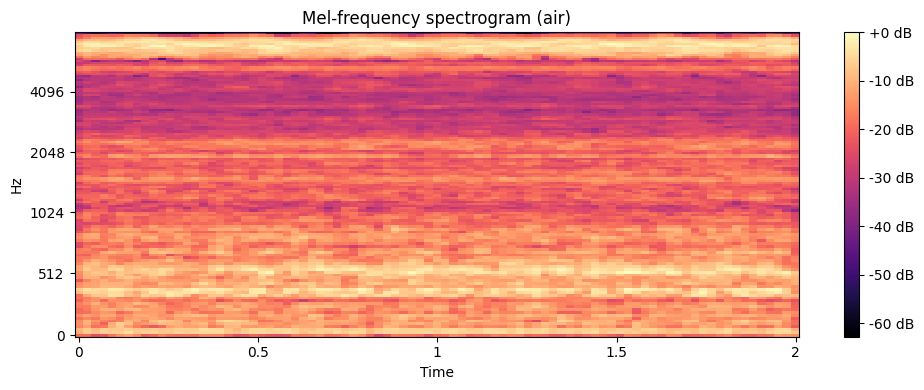

In [249]:
show_sample(samp, title=CATS[0])

In [250]:
samp = get_sample_of(CATS[1])
play_sample(samp)

../data/experiments/v1/vac/g28_huawei_vac_1725874725453_chunk_29.wav vac


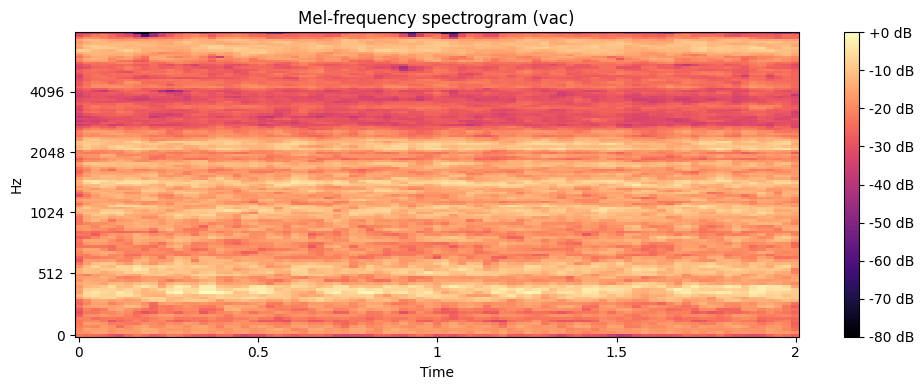

In [251]:
show_sample(samp, title=CATS[1])

In [252]:
samp = get_sample_of(CATS[2])
play_sample(samp)

../data/experiments/v1/off/g28_off_1724341915322_chunk_50.wav off


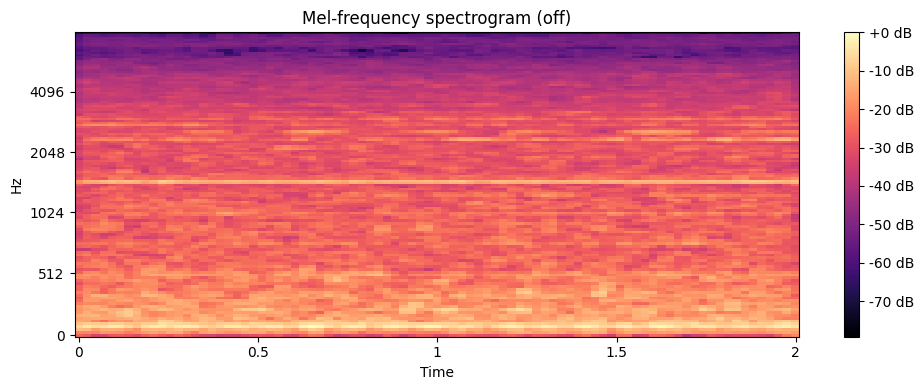

In [253]:
show_sample(samp, title=CATS[2])

## Train/validation split

Split data into training and validation 

In [254]:
from sklearn.model_selection import train_test_split

In [255]:
train, val = train_test_split(df, stratify=df.label, random_state=0, test_size=0.15)
train.shape, val.shape

((538, 3), (96, 3))

In [256]:
df['isval'] = [i in val.index for i in df.index]

In [257]:
df[df.isval]

,filepath,label,duration,isval
9,../data/experiments/v1/air/g28_huawei_air_1726...,air,2.0,True
21,../data/experiments/v1/air/g28_huawei_air_1725...,air,2.0,True
25,../data/experiments/v1/air/g28_air_17243416974...,air,2.0,True
36,../data/experiments/v1/air/g28_huawei_air_1726...,air,2.0,True
39,../data/experiments/v1/air/g28_huawei_air_1726...,air,2.0,True
...,...,...,...,...
599,../data/experiments/v1/off/g28_huawei_off_1726...,off,2.0,True
600,../data/experiments/v1/off/g28_off_17244298328...,off,2.0,True
607,../data/experiments/v1/off/g28_off_17243419153...,off,2.0,True
615,../data/experiments/v1/off/g28_huawei_off_1726...,off,2.0,True


In [258]:
train.label.value_counts()

off    183
air    178
vac    177
Name: label, dtype: int64

In [259]:
val.label.value_counts()

off    33
air    32
vac    31
Name: label, dtype: int64

## Import / download pretrained model (speechbrain urbansound)

In [260]:
import torchaudio
from speechbrain.inference.classifiers import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/urbansound8k_ecapa", savedir="models/gurbansound8k_ecapa")
out_prob, score, index, text_lab = classifier.classify_file('speechbrain/urbansound8k_ecapa/dog_bark.wav')
print(text_lab)

['dog_bark']


For fun, I'm just going to run the classifier which is predicting urban sounds, and see what it says on random samples from our new dataset - it's interesting what it predicts! 

In [261]:
sample = get_sample_of(CATS[0])
classifier.classify_file(sample.filepath)

(tensor([[-0.1059, -0.0274,  0.1141, -0.5768, -0.0877, -0.2688,  0.3275,  0.2400,
           0.4834,  0.0514]]),
 tensor([0.4834]),
 tensor([8]),
 ['drilling'])

In [262]:
play_sample(sample)

../data/experiments/v1/air/g28_air_1724341697486_chunk_17.wav air


In [264]:
sample = get_sample_of(CATS[1], random_state=1)
classifier.classify_file(sample.filepath)

(tensor([[ 0.1376, -0.3050, -0.2093, -0.1708, -0.2196, -0.2893,  0.2454,  0.3200,
           0.5589,  0.2204]]),
 tensor([0.5589]),
 tensor([8]),
 ['drilling'])

In [265]:
play_sample(sample)

../data/experiments/v1/vac/g28_vac_1724429578031_chunk_9.wav vac


## Convert audio to tensors for training 

In [266]:
import torchaudio
import torch

different samples have different length tensor (longer or shorter time series) 

In [267]:
sample = get_sample_of(CATS[0])
tens, size = torchaudio.load(sample.filepath)
tens.shape, size

(torch.Size([1, 88200]), 44100)

the classifier's `load_audio` function does some extra stuff like normalization, so let's use that 


In [268]:
tens = classifier.load_audio(sample.filepath)
tens.shape

torch.Size([32000])

In [269]:
tens.unsqueeze(0).shape

torch.Size([1, 32000])

In [270]:
rel_length =  torch.tensor([1.])
enc = classifier.encode_batch(tens.unsqueeze(0), rel_length)
enc.shape

torch.Size([1, 1, 192])

In [271]:
# probabilities of each class
preds = classifier.mods.classifier(enc).squeeze(1); preds

tensor([[-0.2789, -0.1399,  0.3973, -0.4954, -0.0259, -0.1327,  0.2771,  0.4526,
          0.2573, -0.1806]])

In [272]:
# batch of preds, but just 1 in the batch 
preds.shape

torch.Size([1, 10])

In [273]:
# check that our work agrees with the full implementation 
classifier.classify_file(sample.filepath)

(tensor([[-0.2789, -0.1399,  0.3973, -0.4954, -0.0259, -0.1327,  0.2771,  0.4526,
           0.2573, -0.1806]]),
 tensor([0.4526]),
 tensor([7]),
 ['jackhammer'])

## Create dataset 

In [274]:
from torch.utils.data import Dataset
import torch.nn.functional as F

In [275]:
CATS

['air', 'vac', 'off']

In [276]:
train.head(3)

,filepath,label,duration
631,../data/experiments/v1/off/g28_huawei_off_1726...,off,2.0
13,../data/experiments/v1/air/g28_huawei_air_1726...,air,2.0
525,../data/experiments/v1/off/g28_huawei_off_1726...,off,2.0


In [277]:
val.head(3)

,filepath,label,duration
526,../data/experiments/v1/off/g28_huawei_off_1725...,off,2.0
284,../data/experiments/v1/vac/g28_huawei_vac_1726...,vac,2.0
592,../data/experiments/v1/off/g28_off_test_mon_17...,off,2.0


In [284]:
from functools import cache

class ApplianceDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y 
    def __len__(self): return len(self.y)
    
    @cache
    def __getitem__(self, i):
        y = torch.zeros(3)
        y[CATS.index(self.y[i])] = 1.
        return self.X[i], y

In [285]:
Xtrain = torch.stack([classifier.load_audio(fp) for fp in train.filepath])
Xval = torch.stack([classifier.load_audio(fp) for fp in val.filepath])
ytrain = list(train.label)
yval = list(val.label)
Xtrain.shape, Xval.shape

(torch.Size([538, 32000]), torch.Size([96, 32000]))

In [286]:
train_ds = ApplianceDS(Xtrain, ytrain)
val_ds = ApplianceDS(Xval, yval)

In [287]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
# we don't need batches for the validation set so just put into a big batch 
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)

In [288]:
Xval, yval = next(iter(val_dl))

In [289]:
Xval.shape, yval.shape

(torch.Size([96, 32000]), torch.Size([96, 3]))

In [290]:
def reset_weights():
    classifier.mods.classifier.weight = torch.nn.Parameter(torch.FloatTensor(3, 192))
    torch.nn.init.xavier_uniform_(classifier.mods.classifier.weight)
reset_weights()

In [291]:
for param in classifier.mods.classifier.parameters():
    print(param.requires_grad)

True


In [292]:
classifier.mods.compute_features

Fbank(
  (compute_STFT): STFT()
  (compute_fbanks): Filterbank()
  (compute_deltas): Deltas()
  (context_window): ContextWindow()
)

In [293]:
for mod in classifier.mods:
    print(mod)
    for p in classifier.mods.__getattr__(mod).parameters():
        print(mod, p.requires_grad)
        break

compute_features
mean_var_norm
embedding_model
embedding_model False
classifier
classifier True


In [294]:
loss_fn = torch.nn.CrossEntropyLoss()

In [295]:
train_loss = []
val_loss = []
reset_weights()
optimizer = torch.optim.Adam(classifier.mods.classifier.parameters(), lr=0.001)
for epoch in tqdm(range(100)):
    losses = []
    for batch_idx, (X, y) in enumerate(train_dl):
        logits, confidences, classes, decoded_classes = classifier(X)
        loss = loss_fn(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_loss.append(np.mean(losses))
    
    val_preds, *_ = classifier(Xval)    
    val_loss_ = loss_fn(val_preds, yval)
    val_loss.append(val_loss_.item())

    print(f"Epoch {epoch}: Train Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}")

  1%|▉                                                                                            | 1/100 [00:47<1:18:09, 47.37s/it]

Epoch 0: Train Loss: 1.0797, Validation Loss: 1.0608


  2%|█▊                                                                                           | 2/100 [01:33<1:15:44, 46.37s/it]

Epoch 1: Train Loss: 1.0528, Validation Loss: 1.0359


  3%|██▊                                                                                          | 3/100 [02:18<1:13:57, 45.75s/it]

Epoch 2: Train Loss: 1.0326, Validation Loss: 1.0170


  4%|███▋                                                                                         | 4/100 [03:03<1:12:43, 45.45s/it]

Epoch 3: Train Loss: 1.0190, Validation Loss: 1.0028


  5%|████▋                                                                                        | 5/100 [03:47<1:11:40, 45.27s/it]

Epoch 4: Train Loss: 1.0083, Validation Loss: 0.9926


  6%|█████▌                                                                                       | 6/100 [04:29<1:08:55, 43.99s/it]

Epoch 5: Train Loss: 0.9998, Validation Loss: 0.9853


  7%|██████▌                                                                                      | 7/100 [05:08<1:05:29, 42.25s/it]

Epoch 6: Train Loss: 0.9945, Validation Loss: 0.9789


  8%|███████▍                                                                                     | 8/100 [05:46<1:02:55, 41.04s/it]

Epoch 7: Train Loss: 0.9912, Validation Loss: 0.9755


  9%|████████▎                                                                                    | 9/100 [06:25<1:01:00, 40.23s/it]

Epoch 8: Train Loss: 0.9873, Validation Loss: 0.9726


 10%|█████████▍                                                                                    | 10/100 [07:03<59:28, 39.65s/it]

Epoch 9: Train Loss: 0.9847, Validation Loss: 0.9704


 11%|██████████▎                                                                                   | 11/100 [07:41<58:08, 39.20s/it]

Epoch 10: Train Loss: 0.9825, Validation Loss: 0.9684


 12%|███████████▎                                                                                  | 12/100 [08:19<57:06, 38.93s/it]

Epoch 11: Train Loss: 0.9797, Validation Loss: 0.9670


 13%|████████████▏                                                                                 | 13/100 [08:58<56:13, 38.78s/it]

Epoch 12: Train Loss: 0.9794, Validation Loss: 0.9660


 14%|█████████████▏                                                                                | 14/100 [09:36<55:24, 38.65s/it]

Epoch 13: Train Loss: 0.9775, Validation Loss: 0.9649


 15%|██████████████                                                                                | 15/100 [10:15<54:41, 38.60s/it]

Epoch 14: Train Loss: 0.9773, Validation Loss: 0.9644


 16%|███████████████                                                                               | 16/100 [10:53<53:53, 38.50s/it]

Epoch 15: Train Loss: 0.9772, Validation Loss: 0.9637


 17%|███████████████▉                                                                              | 17/100 [11:31<53:11, 38.46s/it]

Epoch 16: Train Loss: 0.9756, Validation Loss: 0.9634


 18%|████████████████▉                                                                             | 18/100 [12:10<52:30, 38.43s/it]

Epoch 17: Train Loss: 0.9770, Validation Loss: 0.9625


 19%|█████████████████▊                                                                            | 19/100 [12:48<51:49, 38.38s/it]

Epoch 18: Train Loss: 0.9749, Validation Loss: 0.9623


 20%|██████████████████▊                                                                           | 20/100 [13:26<51:10, 38.38s/it]

Epoch 19: Train Loss: 0.9759, Validation Loss: 0.9623


 21%|███████████████████▋                                                                          | 21/100 [14:05<50:31, 38.38s/it]

Epoch 20: Train Loss: 0.9736, Validation Loss: 0.9620


 22%|████████████████████▋                                                                         | 22/100 [14:43<49:58, 38.45s/it]

Epoch 21: Train Loss: 0.9753, Validation Loss: 0.9626


 23%|█████████████████████▌                                                                        | 23/100 [15:22<49:22, 38.48s/it]

Epoch 22: Train Loss: 0.9771, Validation Loss: 0.9624


 24%|██████████████████████▌                                                                       | 24/100 [16:00<48:40, 38.43s/it]

Epoch 23: Train Loss: 0.9770, Validation Loss: 0.9617


 25%|███████████████████████▌                                                                      | 25/100 [16:39<48:01, 38.42s/it]

Epoch 24: Train Loss: 0.9752, Validation Loss: 0.9618


 26%|████████████████████████▍                                                                     | 26/100 [17:17<47:22, 38.41s/it]

Epoch 25: Train Loss: 0.9751, Validation Loss: 0.9619


 27%|█████████████████████████▍                                                                    | 27/100 [17:55<46:43, 38.41s/it]

Epoch 26: Train Loss: 0.9741, Validation Loss: 0.9621


 28%|██████████████████████████▎                                                                   | 28/100 [18:33<45:58, 38.31s/it]

Epoch 27: Train Loss: 0.9727, Validation Loss: 0.9614


 29%|███████████████████████████▎                                                                  | 29/100 [19:12<45:25, 38.39s/it]

Epoch 28: Train Loss: 0.9756, Validation Loss: 0.9615


 30%|████████████████████████████▏                                                                 | 30/100 [19:50<44:44, 38.35s/it]

Epoch 29: Train Loss: 0.9753, Validation Loss: 0.9614


 31%|█████████████████████████████▏                                                                | 31/100 [20:29<44:05, 38.35s/it]

Epoch 30: Train Loss: 0.9770, Validation Loss: 0.9614


 32%|██████████████████████████████                                                                | 32/100 [21:07<43:31, 38.41s/it]

Epoch 31: Train Loss: 0.9735, Validation Loss: 0.9617


 33%|███████████████████████████████                                                               | 33/100 [21:45<42:48, 38.33s/it]

Epoch 32: Train Loss: 0.9726, Validation Loss: 0.9616


 34%|███████████████████████████████▉                                                              | 34/100 [22:24<42:13, 38.38s/it]

Epoch 33: Train Loss: 0.9737, Validation Loss: 0.9621


 35%|████████████████████████████████▉                                                             | 35/100 [23:02<41:36, 38.41s/it]

Epoch 34: Train Loss: 0.9739, Validation Loss: 0.9617


 36%|█████████████████████████████████▊                                                            | 36/100 [23:40<40:53, 38.33s/it]

Epoch 35: Train Loss: 0.9751, Validation Loss: 0.9613


 37%|██████████████████████████████████▊                                                           | 37/100 [24:19<40:18, 38.39s/it]

Epoch 36: Train Loss: 0.9766, Validation Loss: 0.9614


 38%|███████████████████████████████████▋                                                          | 38/100 [24:57<39:35, 38.31s/it]

Epoch 37: Train Loss: 0.9739, Validation Loss: 0.9612


 39%|████████████████████████████████████▋                                                         | 39/100 [25:35<38:58, 38.34s/it]

Epoch 38: Train Loss: 0.9735, Validation Loss: 0.9611


 40%|█████████████████████████████████████▌                                                        | 40/100 [26:14<38:19, 38.32s/it]

Epoch 39: Train Loss: 0.9724, Validation Loss: 0.9615


 41%|██████████████████████████████████████▌                                                       | 41/100 [26:52<37:41, 38.33s/it]

Epoch 40: Train Loss: 0.9751, Validation Loss: 0.9617


 42%|███████████████████████████████████████▍                                                      | 42/100 [27:31<37:17, 38.57s/it]

Epoch 41: Train Loss: 0.9722, Validation Loss: 0.9617


 42%|███████████████████████████████████████▍                                                      | 42/100 [27:46<38:20, 39.67s/it]


KeyboardInterrupt: 

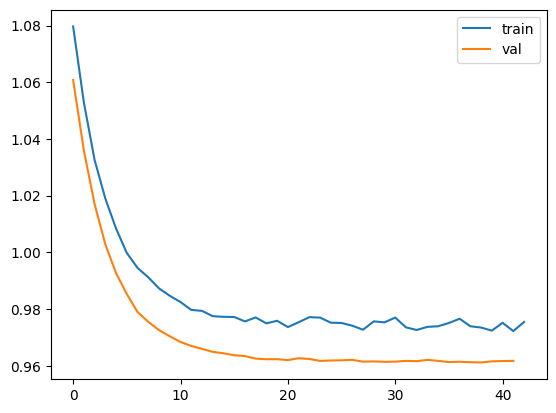

In [296]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train','val'])
plt.show();

### Validation accuracy 

In [297]:
CATS

['air', 'vac', 'off']

In [298]:
preds, *rest = classifier(Xval)

In [299]:
preds.argmax(axis=1)

tensor([2, 2, 0, 0, 2, 1, 0, 1, 1, 0, 1, 2, 1, 2, 2, 2, 0, 2, 1, 0, 2, 2, 2, 0,
        2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 2, 2, 2,
        1, 0, 0, 2, 2, 2, 1, 0, 2, 2, 1, 1, 2, 1, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2,
        1, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 2, 0, 1, 2])

In [300]:
yval.argmax(axis=1)

tensor([2, 0, 0, 0, 2, 2, 0, 1, 1, 1, 1, 2, 1, 2, 0, 1, 0, 2, 2, 0, 2, 0, 2, 1,
        2, 2, 0, 0, 2, 2, 1, 2, 0, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 0, 0, 2, 2,
        0, 0, 0, 1, 0, 0, 2, 0, 2, 2, 1, 2, 1, 1, 0, 0, 0, 1, 1, 2, 1, 0, 0, 2,
        1, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 2])

In [301]:
(preds.argmax(axis=1) == yval.argmax(axis=1)).float().mean()

tensor(0.6771)

### Train accuracy 

In [302]:
torch.tensor([CATS.index(val) for val in ytrain])

tensor([2, 0, 2, 0, 2, 1, 1, 1, 0, 0, 2, 1, 2, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 0, 1, 1, 1, 2, 0, 2, 0, 1, 2, 0, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 0,
        1, 2, 2, 2, 0, 2, 2, 1, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, 1, 1, 0, 1,
        2, 2, 0, 2, 0, 2, 0, 1, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 2, 2, 1, 1, 0, 2,
        1, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 1, 1, 0, 1, 0, 2, 1, 1, 0, 1, 1, 2, 1,
        0, 1, 1, 0, 2, 2, 1, 2, 0, 1, 0, 1, 2, 0, 1, 0, 2, 1, 2, 2, 1, 1, 2, 0,
        1, 1, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 0, 0, 0, 0, 1, 2, 1, 2, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 2, 2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0,
        0, 0, 1, 0, 0, 2, 0, 2, 2, 0, 2, 0, 1, 0, 1, 1, 2, 2, 1, 0, 1, 1, 2, 0,
        1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 2, 0, 1, 2, 0, 0, 1, 1, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 0, 1, 1,
        2, 0, 2, 0, 1, 0, 2, 1, 1, 2, 1, 0, 2, 2, 2, 2, 1, 1, 0, 1, 0, 2, 0, 2,
        2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1,

In [303]:
train_preds, *rest = classifier(Xtrain)
train_preds.argmax(axis=1)

tensor([2, 2, 2, 2, 2, 1, 1, 2, 2, 0, 2, 1, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0,
        1, 2, 2, 1, 0, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0,
        1, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 2, 2, 0, 1, 1, 1, 2, 1, 0, 1,
        2, 1, 2, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 1, 0, 1, 2, 2, 1, 2, 0, 2,
        1, 1, 1, 2, 0, 0, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 2, 1,
        1, 1, 2, 1, 2, 2, 1, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 0,
        1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0,
        0, 1, 1, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 0, 2, 0,
        2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 2, 1, 0, 1, 1, 2, 0,
        1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 0, 1, 2, 1, 2, 0, 2, 2, 0, 1, 0, 1, 0, 2,
        1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 2,
        0, 0, 2, 1, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2, 0, 2,
        2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0,

In [304]:
(torch.tensor([CATS.index(val) for val in ytrain]) == train_preds.argmax(axis=1)).float().mean()

tensor(0.6357)